In [21]:
#import libraries
import numpy as np
import pandas as pd
import sys
import math
import matplotlib.pyplot as plt
import random
from scipy.stats import chisquare

In [22]:
def benford_x_digit(rawdata,digit):
    data_nonzero=filter(lambda n: n !=0. , rawdata)
    data=list(data_nonzero)
    BFD= [math.log10(1.0+1.0/n) for n in range (10**(digit-1),10**digit)]
    data_count={}
    for i in range(10**(digit-1),10**digit):
        data_count[i]=0      
    data_xdigits=[int(str(abs(x*1000))[0:digit]) for x in data]
    for i in range(len(data_xdigits)):
            data_count[data_xdigits[i]]=data_count[data_xdigits[i]]+1
    list_tuples=sorted(data_count.items())
    data_count=[i[1] for i in list_tuples]
    total_count=sum(data_count)
     
    expected_count=[p * total_count for p in BFD]
    #We are not rounding/flooring here because it may be useful to have the 
    #fractions even if it doesnt make sense in real life, just to reconcile totals
    #in the dataframe wrapper I am rounding it anyway.    
    
    #conveniently, in python a function can return several values, in this case
    #we are returning the data count, expected count and expected frequency for 
    #the first n digits and raw data provided. 
    return  data_count, expected_count, BFD
def benford_x_digit_to_dataframe(rawdata,digit):
    c,e,p = benford_x_digit(data,1)
    return pd.DataFrame(tuple(zip((1,2,3,4,5,6,7,8,9),c,np.around(e),p)),columns=['Digit','Count','Exp_count','Exp_freq'])

#Now a test with dummy data to see how it works without having to load external data
print("Test values:")
data=[0,0,0,0,-1,11,1.11,0.1111,1,1,1,1,1,1,1,2,2,2,2,2,2,3,3,3,3,4,4,4,5,5,5,6,6,7,7,8,8,9,9]
# This list should match exactly the expected count, i.e. 11,6,4,3,3,2,2,2,2
benford_x_digit_to_dataframe(data,1)


Test values:


,Digit,Count,Exp_count,Exp_freq
0,1,11,11.0,0.301030
1,2,6,6.0,0.176091
2,3,4,4.0,0.124939
3,4,3,3.0,0.096910
4,5,3,3.0,0.079181
5,6,2,2.0,0.066947
6,7,2,2.0,0.057992
7,8,2,2.0,0.051153
8,9,2,2.0,0.045757


In [23]:
def plot_benford(data,digit):   
    data_count, expected_count, p =benford_x_digit(data,digit)
    y1 = expected_count
    y2 = data_count
    x= np.arange(10**(digit-1),10**digit)
    bins = np.linspace(1, 10)
    width=.35
    plt.bar(x, y2, width, label="Actual")
    plt.bar(x+width, y1, width, label="Benford")
    plt.xticks(x+width/2 , x)
    plt.legend(loc='upper right')
    plt.show()

In [24]:
df= pd.read_excel("./test_data/data.xlsx")
df

,field1,field2,field3
0,-241,4708,2191
1,-29,1617,236
2,0,14,81
3,9,-728,938
4,37,9056,-4288
...,...,...,...
99995,39,-2464,1369
99996,50,-1140,251
99997,0,12,57
99998,39,485,-718


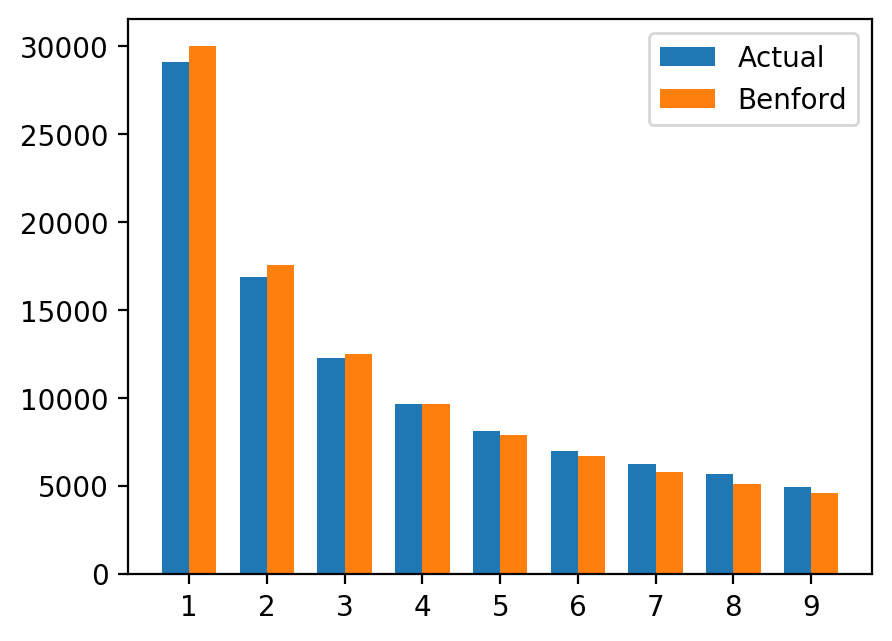

In [25]:
digit=1
data=df["field3"].tolist()
plot_benford(data,digit)

In [26]:
#if we want the actual data
benford_x_digit_to_dataframe(data,1)

,Digit,Count,Exp_count,Exp_freq
0,1,29075,30032.0,0.301030
1,2,16856,17568.0,0.176091
2,3,12271,12465.0,0.124939
3,4,9631,9668.0,0.096910
4,5,8105,7900.0,0.079181
5,6,6976,6679.0,0.066947
6,7,6251,5786.0,0.057992
7,8,5658,5103.0,0.051153
8,9,4942,4565.0,0.045757


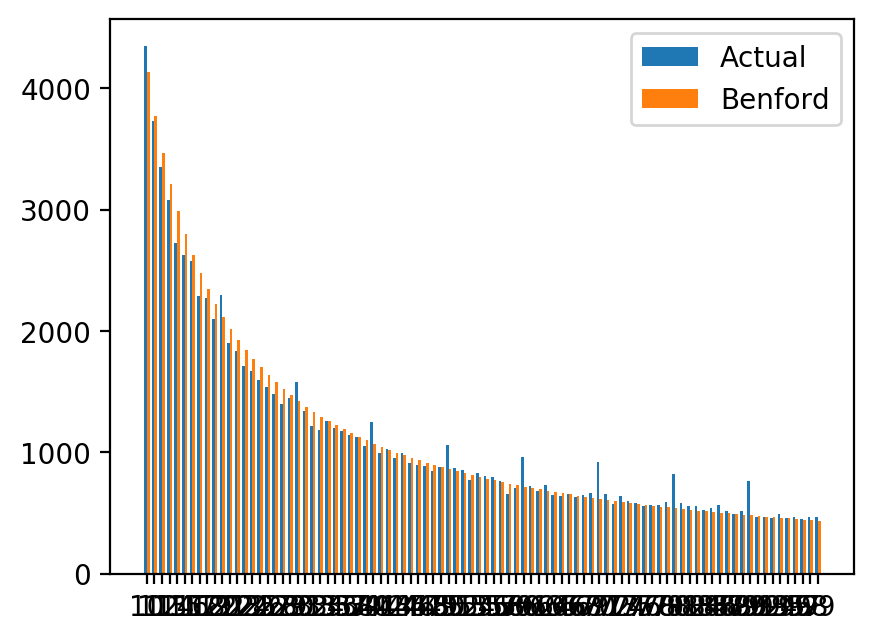

In [27]:
digit=2
data=df["field3"].tolist()
plot_benford(data,digit)

In [32]:
anomalies=[]
digit=2
data_count, expected_count, p =benford_x_digit(data,digit)
for i in range(len(data_count)):
    diff = abs(expected_count[i]-data_count[i])
    diff_perc=abs(diff/expected_count[i])
    anomalies.append([range(10**(digit-1),10**digit)[i],data_count[i],expected_count[i],diff, diff_perc])


In [33]:
df_anomalies=pd.DataFrame(anomalies,columns=["digit","count","expected","diff","diff_perc"])
df_anomalies.sort_values(by="diff", ascending=False)

,digit,count,expected,diff,diff_perc
60,70,922,614.583198,307.416802,0.500204
80,90,762,478.760551,283.239449,0.591610
70,80,820,538.235356,281.764644,0.523497
4,14,2720,2989.280980,269.280980,0.090082
50,60,959,716.171495,242.828505,0.339065
...,...,...,...,...,...
39,49,879,875.330559,3.669441,0.004192
56,66,654,651.551962,2.448038,0.003757
24,34,1254,1255.954286,1.954286,0.001556
78,88,489,489.580226,0.580226,0.001185


This does the Chi Square test, but tends to be problematic with high numbers due to high degrees of freedom, from the documentation you probably can't use it Benford)

In [31]:
def chisquare_test(data_count,digit):
    total_count=sum(data_count)  
    BFD= [math.log10(1.0+1.0/n) for n in range (10**(digit-1),10**digit)]
    exp_count=[int(p * total_count) for p in BFD]      
    chi_sqr, pvalue = chisquare(data_count, f_exp=exp_count) 
    return chi_sqr , pvalue
digit=2
data_count, expected_count, p =benford_x_digit(data,digit)
total_count=sum(data_count)  
data_count
chi_sqr, pvalue = chisquare_test(data_count,digit)
print("CHI square statistic:",chi_sqr)
print("p value",pvalue)


CHI square statistic: 904.1025911196125
p value 4.1636274817654455e-135
